Fairness, Explainability & Ethical AI: Model Analysis Report
Introduction to Ethical AI

Ethical Artificial Intelligence focuses on building systems that are fair, transparent, and accountable. Bias in data and models can lead to unfair outcomes for specific groups, especially when sensitive attributes such as gender, race, or age are involved.
This project evaluates a classification model not only by accuracy, but also by how fair and explainable its decisions are, using Fairlearn, SHAP, and LIME.

Dataset Description & Preprocessing

The dataset used in this study is the Adult Income Dataset (UCI), which predicts whether a person earns > $50K annually.

Preprocessing Steps

Removed missing values (“?”).

One-hot encoded categorical variables using pd.get_dummies(drop_first=True).

Scaled numerical variables using StandardScaler().

Target variable:

0 = <=50K

1 = >50K

Sensitive attribute selected for fairness analysis:

Sex (0 = Female, 1 = Male)

Final shape after encoding:

100 features, thousands of samples.

 Model Training & Evaluation

A Logistic Regression classifier was trained with 200 iterations.

Performance Metrics
Metric	Score
Accuracy	0.8537
Precision (>50K)	0.74
Recall (>50K)	0.61
F1-Score (>50K)	0.67
Confusion Matrix
[[6902  515]
 [ 914 1438]]

Interpretation

The model performs well overall.

It is better at identifying <=50K earners than >50K earners.

This imbalance is common due to class distribution.

 Fairness Analysis (Using Fairlearn)

The model was evaluated across the sensitive attribute Sex.

Metrics by Group
Sex	Selection Rate	False Positive Rate	True Positive Rate
Female (0)	0.0847	0.0249	0.5587
Male (1)	0.2560	0.0970	0.6208
Key Findings

Selection rate for males (25.6%) is 3× higher than for females (8.4%)
→ Model is more likely to predict >50K for men.

False positive rate is higher for men, meaning men are incorrectly labeled as high earners more often.

True positive rate also favors men, showing performance advantage.

Conclusion

The model displays gender bias, performing better for men across all fairness metrics.

 Explainability Analysis
SHAP (Global Explainability)

SHAP values showed the most influential features globally:

marital-status_Married-civ-spouse

capital-gain

education-num

sex_Male

age

Insights

Married individuals strongly contribute to >50K predictions.

sex_Male shows noticeable impact → gender is influencing predictions.

Higher education, age, and capital gain predict higher income.

SHAP Waterfall (Local Explanation)

For an individual instance:

Features like marital status, occupation, and sex_Male increased the income prediction.

Others like lower education-num reduced it.

LIME (Local Explainability)

LIME highlighted:

Positive contributors (e.g., occupation, marital status)

Negative contributors (e.g., low capital gain, lower education)

Both SHAP and LIME confirm consistent influential features, improving trust through transparency.

 Ethical Considerations & Recommendations
What the results show

The model is accurate but not fair across gender.

Sensitive attribute (“sex”) influences the outcome indirectly through encoded variables.

The imbalance in true/false positive rates indicates systemic gender bias.

Recommendations

✔ Apply fairness constraints (equalized odds / demographic parity) using Fairlearn mitigation.
✔ Remove or limit sensitive leakage features (occupation, marital-status patterns).
✔ Re-sample the dataset to balance gender distribution.
✔ Consider fairness-aware algorithms (e.g., adversarial debiasing).
✔ Continuously monitor fairness metrics during deployment.

 Conclusion

This project demonstrates the importance of combining predictive performance with fairness and explainability.
While Logistic Regression performs well overall, fairness metrics reveal gender bias, and explainability tools (SHAP + LIME) confirm that both gender and gender-correlated features influence predictions.

Improving this model requires incorporating fairness constraints, revisiting preprocessing decisions, and continuously evaluating ethical impacts to ensure an equitable AI system.

In [4]:
!pip install fairlearn shap lime


In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate

import shap
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# Make plots show in the notebook
%matplotlib inline


In [6]:
# Column names for the Adult dataset
cols = [
    "age","workclass","fnlwgt","education","education-num",
    "marital-status","occupation","relationship","race","sex",
    "capital-gain","capital-loss","hours-per-week","native-country","income"
]

# ✅ Working URL from UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Load dataset
df = pd.read_csv(
    url,
    names=cols,
    na_values=" ?",
    skipinitialspace=True
)

# Drop rows with missing values
df.dropna(inplace=True)

df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [10]:
# Sensitive attribute
sensitive_feature_name = "sex"

# ✅ Correct target: strip spaces and compare
y = (df["income"].str.strip() == ">50K").astype(int)

# Features (drop the target)
X = df.drop("income", axis=1)

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Sensitive attribute: 1 = Male, 0 = Female
sensitive_feature = (df["sex"].str.strip() == "Male").astype(int)

# Optional: check class balance
print(y.value_counts())
X_encoded.head()


income
0    24720
1     7841
Name: count, dtype: int64


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,215646,9,0,0,40,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
3,53,234721,7,0,0,40,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,40,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train-test split (also split the sensitive feature)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X_encoded,
    y,
    sensitive_feature,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("y_train value counts:\n", y_train.value_counts())


Train shape: (22792, 100)  Test shape: (9769, 100)
y_train value counts:
 income
0    17303
1     5489
Name: count, dtype: int64


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression(max_iter=200)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("✅ Model trained")

# Quick check
print("Sample predictions:", y_pred[:10])


✅ Model trained
Sample predictions: [0 0 0 0 1 0 0 0 0 0]


In [13]:
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8537209540382844

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      7417
           1       0.74      0.61      0.67      2352

    accuracy                           0.85      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.85      0.85      9769


Confusion Matrix:

[[6902  515]
 [ 914 1438]]


=== Fairness metrics by group (0 = Female, 1 = Male) ===
     selection_rate  false_positive_rate  true_positive_rate
sex                                                         
0          0.084714             0.024991            0.558659
1          0.256012             0.097028            0.620863


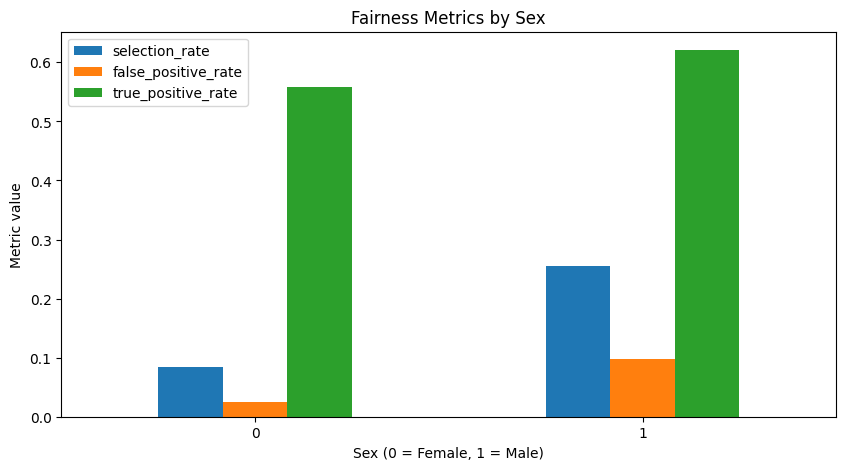

In [14]:
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import matplotlib.pyplot as plt

metrics_dict = {
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate
}

mf = MetricFrame(
    metrics=metrics_dict,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=s_test  # 1 = Male, 0 = Female
)

print("=== Fairness metrics by group (0 = Female, 1 = Male) ===")
print(mf.by_group)

# Bar plot for visual comparison
mf.by_group.plot(kind="bar", figsize=(10, 5))
plt.title("Fairness Metrics by Sex")
plt.xlabel("Sex (0 = Female, 1 = Male)")
plt.ylabel("Metric value")
plt.xticks(rotation=0)
plt.show()


In [15]:
import shap

explainer = shap.LinearExplainer(model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)
print("SHAP values shape:", np.array(shap_values).shape)


SHAP values shape: (9769, 100)


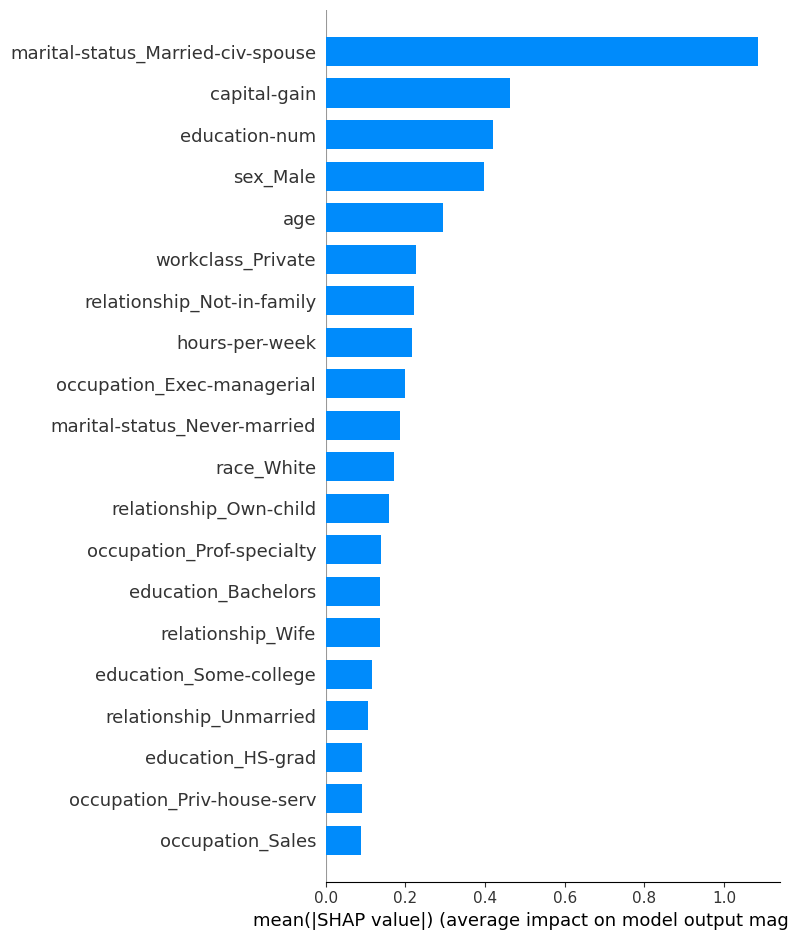

In [16]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


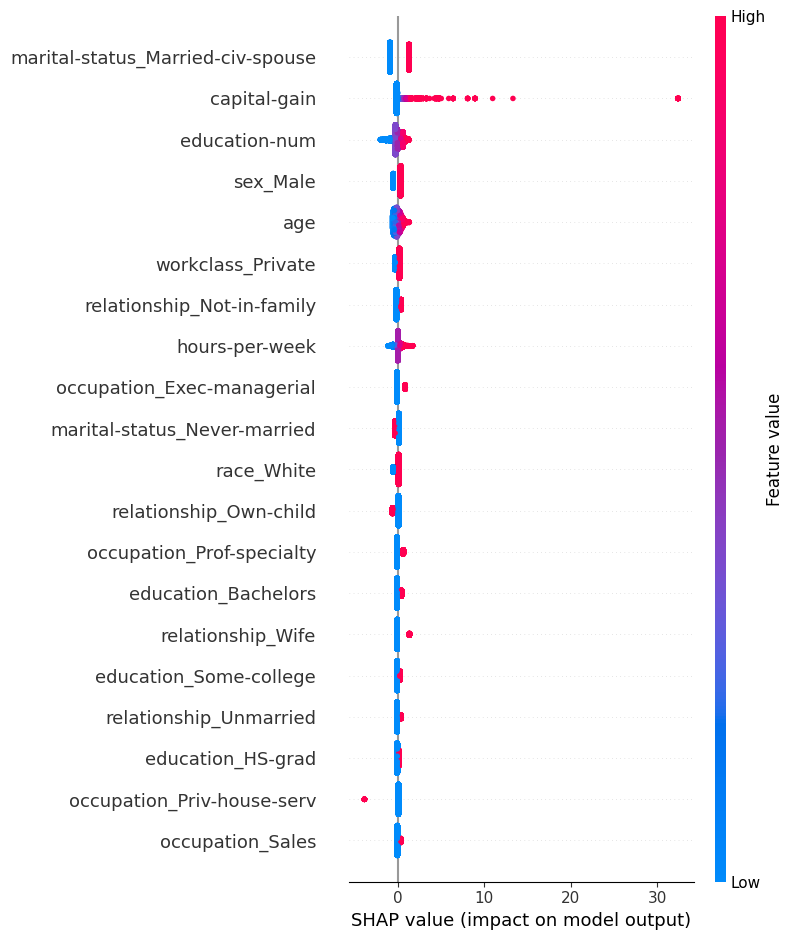

In [17]:
shap.summary_plot(shap_values, X_test)


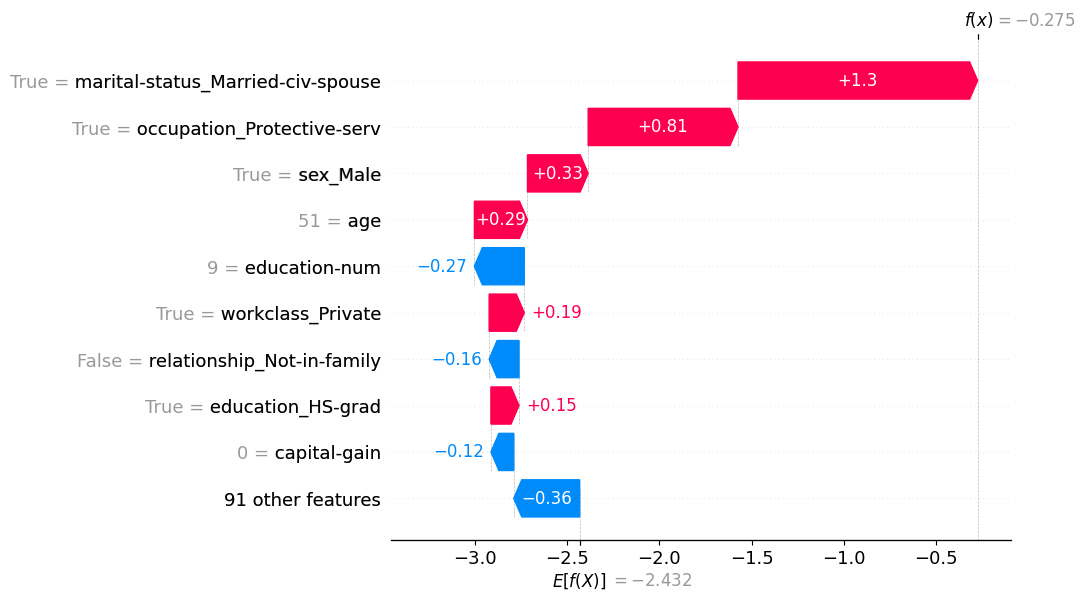

In [18]:
i = 0  # index of the instance you want to explain

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_test.iloc[i],
        feature_names=X_test.columns
    )
)


In [19]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X_train.columns,
    class_names=['<=50K', '>50K'],
    mode='classification'
)

# Explain the same instance as SHAP
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_scaled[0],
    predict_fn=model.predict_proba
)

lime_exp.show_in_notebook()
